In [1]:
# from drive
!unzip ./drive/MyDrive/single-person-pose-estimation/dataset/tfrecords.zip

Archive:  ./drive/MyDrive/single-person-pose-estimation/dataset/tfrecords.zip
   creating: dataset/tfrecords/
   creating: dataset/tfrecords/train/
  inflating: dataset/tfrecords/train/file_train_42-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_24-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_58-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_03-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_48-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_32-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_64-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_45-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_18-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_11-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_40-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_16-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_50-2048.tfrec  
  inflating: dataset

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
import sys
sys.path.append('/content/drive/MyDrive/single-person-pose-estimation')

In [3]:
from configs import default_config as cfg
from model.hourglass import create_hourglass_model
from dataset_builder import DatasetBuilder
from utilities import data_utils

In [5]:
ds_builder = DatasetBuilder(cfg)

Train dataset with 66 tfrecords and 134214 examples.
Valid dataset with 3 tfrecords and 5647 examples.


In [5]:
ds = ds_builder.get_ds_prediction()

In [ ]:
COCO_KEYPOINT_LABELS = ["nose", 
                        "left_eye", "right_eye", 
                        "left_ear", "right_ear", 
                        "left_shoulder", "right_shoulder", 
                        "left_elbow", "right_elbow", 
                        "left_wrist", "right_wrist", 
                        "left_hip", "right_hip", 
                        "left_knee", "right_knee", 
                        "left_ankle", "right_ank"]
len(COCO_KEYPOINT_LABELS)

17

In [ ]:
# keep nose, swap everything else
COCO_INDEX_FLIP_PAIRS = [[1, 2],
                         [3, 4],
                         [5, 6],
                         [7, 8],
                         [9, 10],
                         [11, 12],
                         [13, 14],
                         [15, 16]]
COCO_INDEX_FLIP_PAIRS                 

[[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16]]

In [ ]:
COCO_JOINTS =  np.array([[16, 14],
                        [14, 12],
                        [17, 15],
                        [15, 13],
                        [12, 13],
                        [6, 12],
                        [7, 13],
                        [6, 7],
                        [6, 8],
                        [7, 9],
                        [8, 10],
                        [9, 11],
                        [2, 3],
                        [1, 2],
                        [1, 3],
                        [2, 4],
                        [3, 5],
                        [4, 6],
                        [5, 7]]) - 1
COCO_JOINTS

array([[15, 13],
       [13, 11],
       [16, 14],
       [14, 12],
       [11, 12],
       [ 5, 11],
       [ 6, 12],
       [ 5,  6],
       [ 5,  7],
       [ 6,  8],
       [ 7,  9],
       [ 8, 10],
       [ 1,  2],
       [ 0,  1],
       [ 0,  2],
       [ 1,  3],
       [ 2,  4],
       [ 3,  5],
       [ 4,  6]])

In [6]:
ds_train, ds_valid = ds_builder.build_datasets()

In [9]:
it = iter(ds_train)

In [10]:
imgs_batch, hms_batch = next(it)

In [8]:
def heatmaps_to_keypoints_v1(heatmaps, conf_threshold = 1e-6):
  ''' Work for one batch
  :param heatmaps: shape(64, 64, number of keypoints)
  :return np.array
  '''
  keypoints = np.zeros(shape=(17, 3), dtype=np.float32)
  for i in range(17):
    heatmap = heatmaps[:,:,i]
    index = np.argmax(heatmap) # return index when flattened
    x = index%64
    y = index//64
    conf = heatmap[y, x]
    if conf > conf_threshold:
      keypoints[i, 0] = x
      keypoints[i, 1] = y
      keypoints[i, 2] = conf
    else:
      keypoints[i, 0] = 0
      keypoints[i, 1] = 0
      keypoints[i, 2] = 0
  return keypoints

In [9]:
img = imgs_batch[1]
hms = hms_batch[1]
kps = heatmaps_to_keypoints_v1(hms)

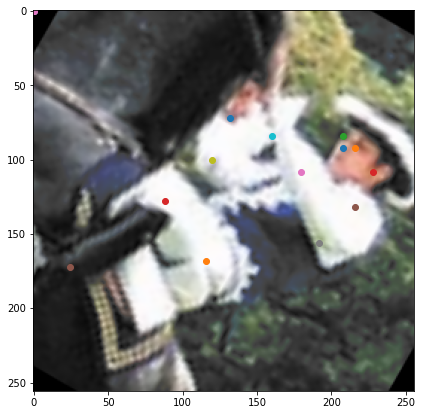

In [10]:
plt.figure(figsize =(7,7))
plt.imshow(img)
for kp in kps:
  plt.plot((kp[0]/64)*256, (kp[1]/64)*256, marker = 'o')

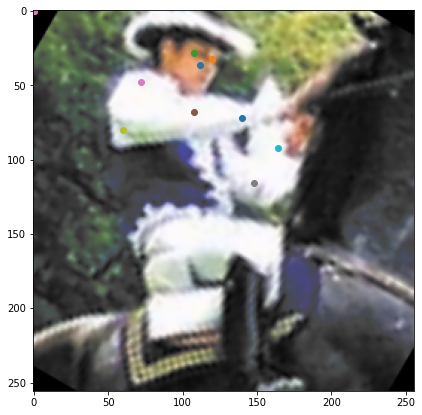

In [10]:
#flip
plt.figure(figsize =(7,7))
plt.imshow(img)
for kp in kps:
  plt.plot((kp[0]/64)*256, (kp[1]/64)*256, marker = 'o')

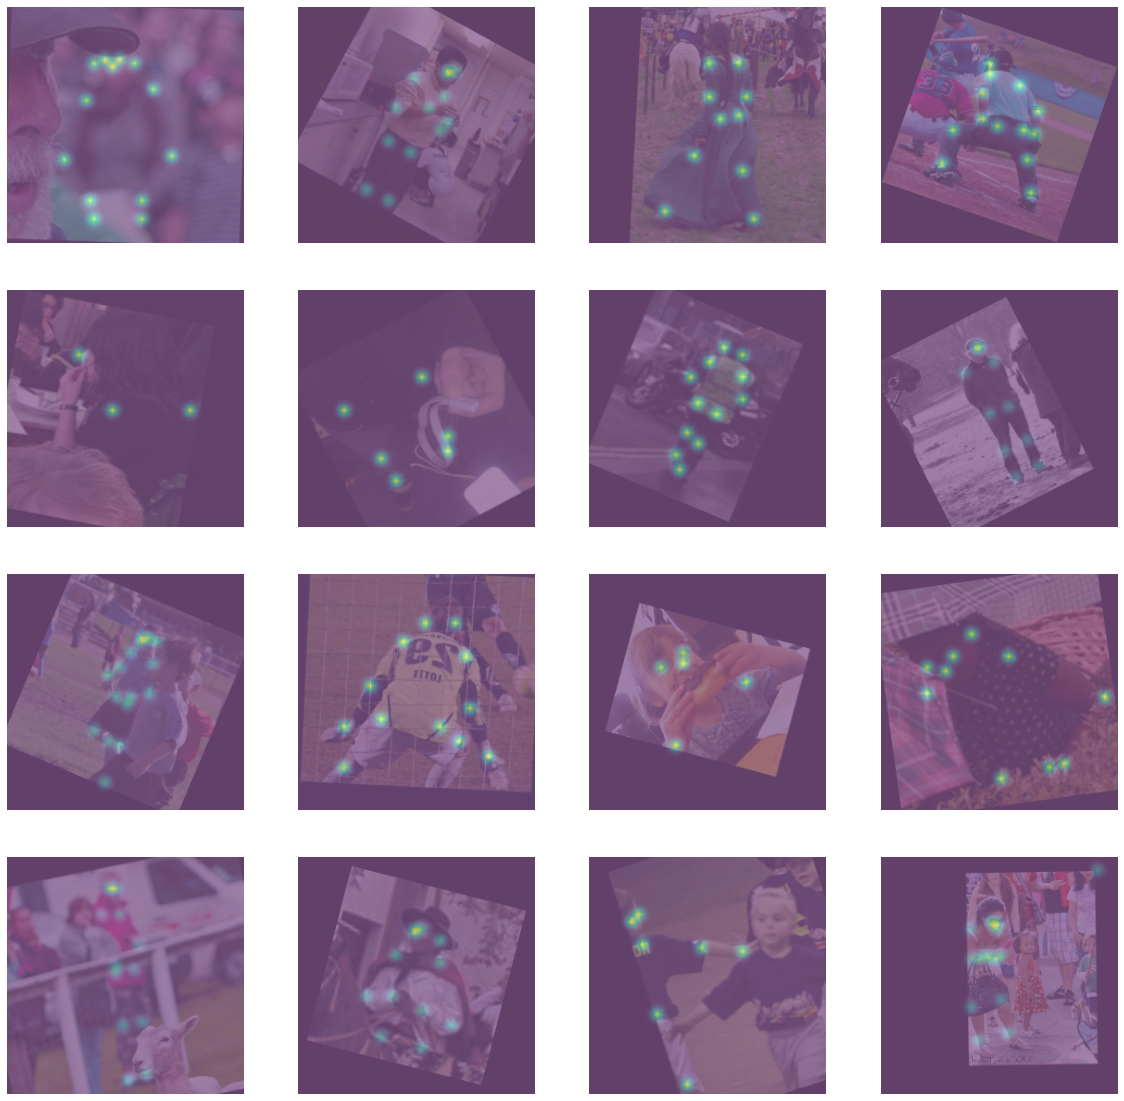

In [15]:
#Truth ground
imgs_batch, hms_batch = next(it)
plt.figure(figsize=(20,20))
for i in range(16):
    ax = plt.subplot(16/4, 16/4, i + 1)
    plt.imshow(imgs_batch[i], cmap = 'gray', alpha = 0.5)
    h = tf.image.resize(hms_batch[i], (256, 256))
    plt.imshow(tf.reduce_sum(h, axis = -1), alpha = 0.5)
    plt.axis("off")